# This is a sample Jupyter Notebook


## Basic Info

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("data/Corona_NLP_train.csv", encoding='latin1')

# Show basic info

print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())

Dataset shape: (41157, 6)

Column names: ['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment']

Missing values:
 UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


## Distributions

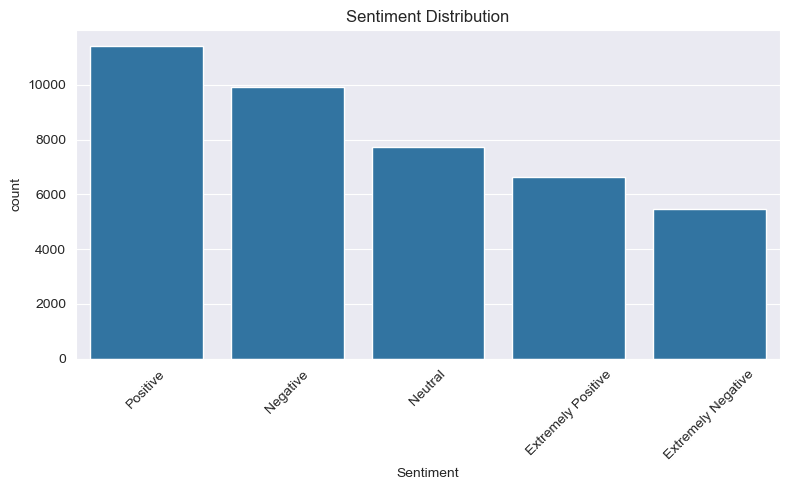

In [30]:

# Sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="Sentiment", order=df["Sentiment"].value_counts().index)
plt.title("Sentiment Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


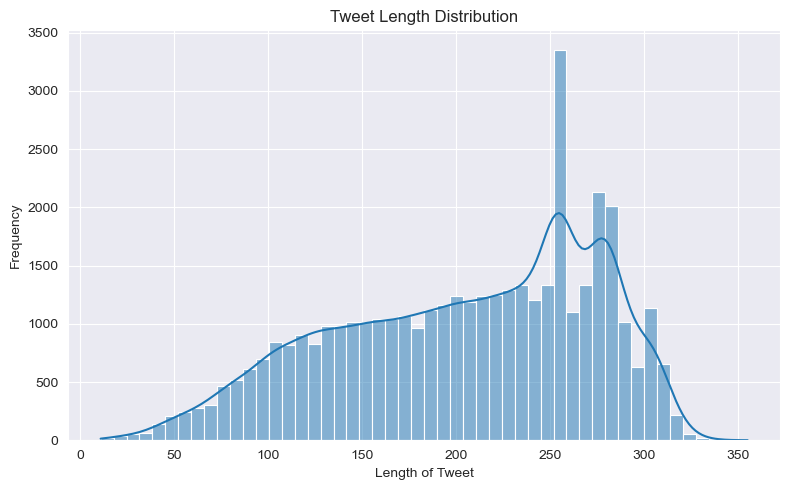

In [31]:
# Tweet length distribution
df['TweetLength'] = df['OriginalTweet'].astype(str).apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df['TweetLength'], bins=50, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Length of Tweet")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Examples

In [32]:
# Example tweet per sentiment
print('Example tweet per sentiment:')
for sentiment in df["Sentiment"].unique():
    example = df[df["Sentiment"] == sentiment]["OriginalTweet"].iloc[0]
    print(f"\nExample - {sentiment}:\n{example}")

Example tweet per sentiment:

Example - Neutral:
@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8

Example - Positive:
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order

Example - Extremely Negative:
Me, ready to go at supermarket during the #COVID19 outbreak.

Not because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...

#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n

Example - Negative:
For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight again

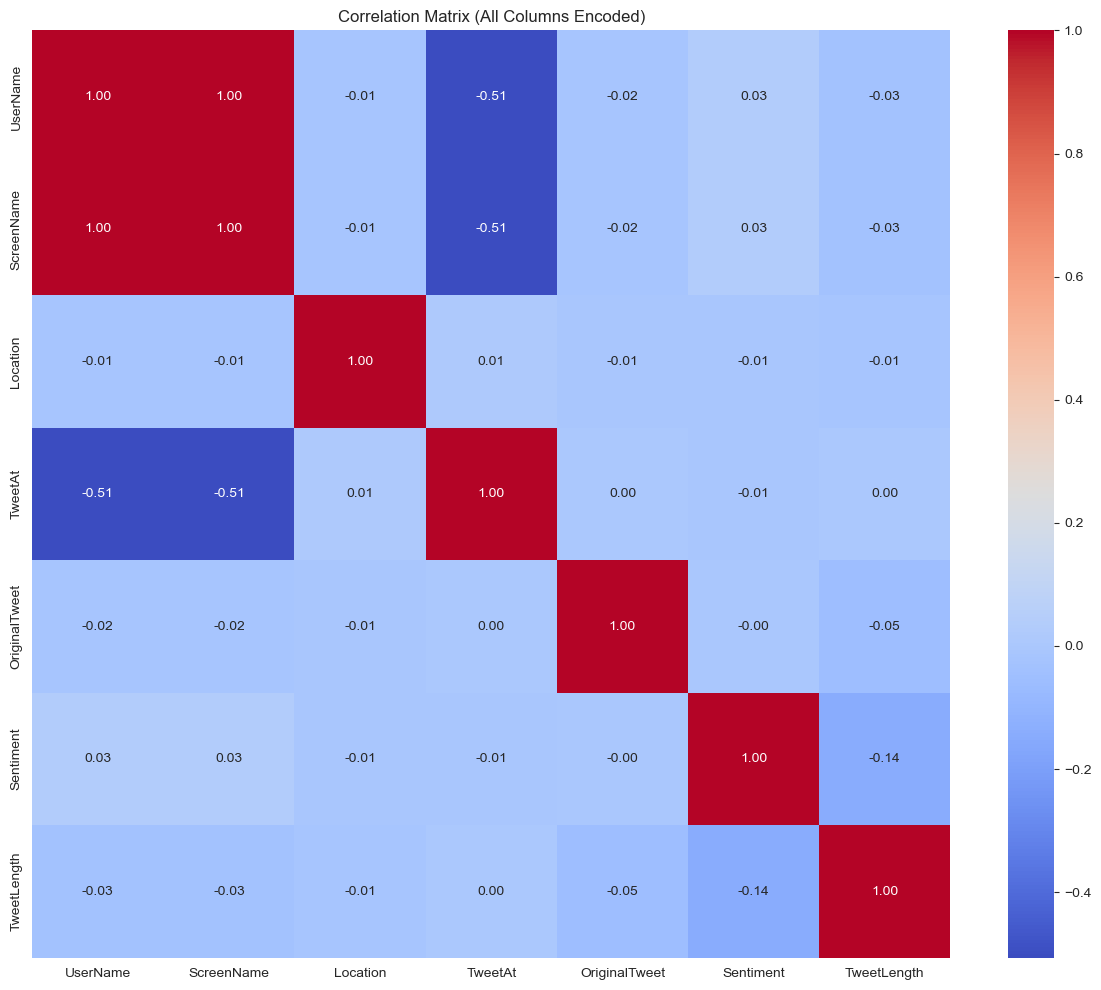

In [34]:
from sklearn.preprocessing import LabelEncoder
# Encode all categorical columns numerically
df_encoded = df.copy()
label_encoders = {}

for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le  # Save encoder if needed later

# Correlation matrix
corr_matrix = df_encoded.corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (All Columns Encoded)")
plt.tight_layout()
plt.show()

In [45]:
df["Sentiment"].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [3]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset
import numpy as np
import torch
import os
import wandb

# Configuration
model_names = [
     "distilbert-base-uncased",
    "huawei-noah/TinyBERT_General_4L_312D",
]
num_labels = 5
max_length = 128
batch_size = 128
output_base_dir = "./models/"
project_name = "corona-nlp-ensemble"

# Label mapping
label2id = {
    "Extremely Negative": 0,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3,
    "Extremely Positive": 4
}
id2label = {v: k for k, v in label2id.items()}

# Load the dataset from local CSV

dataset = load_dataset("csv", data_files={
    "train": "data/Corona_NLP_train.csv",
    "test": "data/Corona_NLP_test.csv"
},
                       encoding="latin1"
)

# Add encoded label column
def encode_labels(example):
    example["label"] = label2id[example["Sentiment"]]
    return example

dataset = dataset.map(encode_labels)

# Preprocessing function
def preprocess(example, tokenizer):
    return tokenizer(
        example["OriginalTweet"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).astype(float).mean().item()
    return {"accuracy": accuracy}


split = dataset["train"].train_test_split(test_size=0.2, seed=42)

# Train each model separately
for i, model_name in enumerate(model_names):
    print(f"Training model {i+1}/{len(model_names)}: {model_name}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized = split.map(lambda x: preprocess(x, tokenizer), batched=True)
    tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    wandb.init(project=project_name, name=f"model_{i}_{model_name.replace('/', '_')}", reinit=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir="./test_output",
        eval_strategy="epoch",
        per_device_train_batch_size=128,
        num_train_epochs=5,
        do_train=True,
        do_eval=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    trainer.save_model(os.path.join(output_base_dir, f"model_{i}"))
    tokenizer.save_pretrained(os.path.join(output_base_dir, f"model_{i}"))
    wandb.finish()

print("All ensemble models trained and saved.")

Training model 1/2: distilbert-base-uncased


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Amit\AppData\Local\Temp\ipykernel_14784\1003048086.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.611036,0.764942
2,0.698400,0.438008,0.843416
3,0.698400,0.410171,0.857993
4,0.289500,0.401106,0.870748
5,0.289500,0.418319,0.866983


C:\Users\Amit\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Amit\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Amit\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


eval/accuracy,▁▆▇██
eval/loss,█▂▁▁▂
eval/runtime,█▂▁▁▃
eval/samples_per_second,▁▇██▆
eval/steps_per_second,▁▇██▆
train/epoch,▁▃▃▅▆▆██
train/global_step,▁▃▃▅▆▆██
train/grad_norm,▁█
train/learning_rate,█▁
train/loss,█▁
eval/accuracy,0.86698


Training model 2/2: huawei-noah/TinyBERT_General_4L_312D


Map:   0%|          | 0/8232 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Amit\AppData\Local\Temp\ipykernel_14784\1003048086.py:93: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.787300,0.704446
2,0.910100,0.632063,0.772716
3,0.910100,0.565457,0.795675
4,0.527400,0.537459,0.805515
5,0.527400,0.531578,0.808431


C:\Users\Amit\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Amit\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Amit\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


eval/accuracy,▁▆▇██
eval/loss,█▄▂▁▁
eval/runtime,▁▃▂▂█
eval/samples_per_second,█▆▇▇▁
eval/steps_per_second,█▆▇▇▁
train/epoch,▁▃▃▅▆▆██
train/global_step,▁▃▃▅▆▆██
train/grad_norm,▁█
train/learning_rate,█▁
train/loss,█▁
eval/accuracy,0.80843


All ensemble models trained and saved.


In [13]:
import torch
from transformers import AutoTokenizer,AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from torch.nn import functional as F
from torch import nn
import numpy as np

raw_datasets = load_dataset("csv",data_files={"train": "data/Corona_NLP_train.csv", "test": "data/Corona_NLP_test.csv"}, encoding="latin1")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize(batch):
    return tokenizer(
        batch["OriginalTweet"],
        padding="max_length",
        truncation=True,
        max_length=max_length)

tokenized = raw_datasets.map(tokenize, batched=True)
tokenized.set_format("torch", columns=["input_ids", "attention_mask",
"Sentiment"])

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5, id2label=label2id, label2id=label2id)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).astype(float).mean().item()
    return {"accuracy": accuracy}




Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
args = TrainingArguments(
output_dir="./results",
eval_strategy="epoch",
per_device_train_batch_size=8,
per_device_eval_batch_size=8,
num_train_epochs=1,
logging_dir="./logs",
logging_steps=10,
save_strategy="no"
)
trainer = Trainer(
model=model,
args=args,
train_dataset=tokenized["train"],
eval_dataset=tokenized["test"],
compute_metrics=compute_metrics
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`